<a href="https://colab.research.google.com/github/AlviJohn/AmazonRecoEngine/blob/main/Product_Recommendation__V4(With_Features).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Importing required libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
import gzip
import json
from google.colab import drive
import gc
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display
import matplotlib.pyplot as plt
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
from tqdm.notebook import tqdm
from sklearn.metrics import ndcg_score, roc_auc_score, precision_score, recall_score, confusion_matrix
## Amazon Dataset --https://nijianmo.github.io/amazon/index.html
###Mounting Google Drive

cuda:0


In [2]:
##Mounting the Path
drive.mount('/content/drive')
path ="/content/drive/MyDrive/LJMU Research Topic/colab_experiments/data"
RAWDATA_PATH = path + "/raw"
EMBEDDINGSDATA_PATH = path + "/embeddings"
MODEL_PATH = EMBEDDINGSDATA_PATH +"/Model_Pantry_AllFeatures_V2(MSELoss).pt"
os.chdir(RAWDATA_PATH)


Mounted at /content/drive


In [3]:
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', )
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
__pyTorch VERSION: 2.0.1+cu118
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
__CUDNN VERSION: 8700
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


**Dataset Definition**

In [4]:
# Define a custom dataset class for reading the data

class AmazonDataset(Dataset):
    def __init__(self, data,idx_to_item,image_embeddings,desc_embeddings):
        self.data = data
        self.idx_to_item = idx_to_item
        self.image_embeddings=image_embeddings
        self.desc_embeddings=desc_embeddings

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user = self.data.iloc[idx, 0]
        item = self.data.iloc[idx, 1]
        relevance_score = self.data.iloc[idx, 2]
        
        itemimage_embedding = self.image_embeddings.get(idx_to_item[item],torch.zeros(25088))
        itemdesc_embedding = self.desc_embeddings.get(idx_to_item[item],torch.zeros(768))

        return user, item, relevance_score,itemimage_embedding,itemdesc_embedding


In [5]:
# Define the model
class RecommenderNet(torch.nn.Module):
    def __init__(self, n_users, n_items,n_image_embedding,n_desc_embedding, n_factors=64,dropout_prob=0.2):
        super().__init__()
        self.user_embedding = torch.nn.Embedding(n_users, n_factors)
        self.item_embedding = torch.nn.Embedding(n_items, n_factors)
        
        self.image_embedding_layer = torch.nn.Linear(n_image_embedding, n_factors)
        self.desc_embedding_layer = torch.nn.Linear(n_desc_embedding, n_factors)
        
        self.fc1 = torch.nn.Linear(n_factors*4, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 1)

        self.dropout = torch.nn.Dropout(dropout_prob)

    def forward(self, user, item,itemimage_embedding,itemdesc_embedding):
       
        user_embedding = self.user_embedding(user)
        item_embedding = self.item_embedding(item)
        
        itemimage_embedding = self.image_embedding_layer(itemimage_embedding).unsqueeze(1)
        itemdesc_embedding = self.desc_embedding_layer(itemdesc_embedding).unsqueeze(1)

        user_embedding = torch.nn.functional.relu(user_embedding)
        user_embedding =self.dropout(user_embedding)
        item_embedding = torch.nn.functional.relu(item_embedding)
        item_embedding =self.dropout(item_embedding)
        
        itemimage_embedding = torch.nn.functional.relu(itemimage_embedding)
        itemimage_embedding =self.dropout(itemimage_embedding)
        itemdesc_embedding = torch.nn.functional.relu(itemdesc_embedding)
        itemdesc_embedding =self.dropout(itemdesc_embedding)

        vector = torch.cat([user_embedding, item_embedding,itemimage_embedding,itemdesc_embedding], dim=-1)
        vector = torch.nn.functional.relu(self.fc1(vector))
        vector = self.dropout(vector)
        vector = torch.nn.functional.relu(self.fc2(vector))
        vector = self.dropout(vector)
        vector = self.fc3(vector)
        vector = torch.sigmoid(vector).float()
        return vector.squeeze().float()

**Model Training**

In [6]:
######Loading Image embeddings
image_embeddings=torch.load(EMBEDDINGSDATA_PATH + '/productimage_embeddings_pantry.pt')
description_embeddings=torch.load(EMBEDDINGSDATA_PATH +'/productdescription_embeddings_pantry.pt')

In [7]:
####Loading the ratings dataset
df = pd.read_csv('user_item_rating_pantry.csv')
df = df[["reviewerID","asin","overall","unixReviewTime"]]

##Assigning all positive rating as 1
#df['overall'] =1
###Taking Unique User IDs and Product IDs
user_unique = df['reviewerID'].unique()
product_unique= df['asin'].unique()

###Creating index for UserID and Product ID
user_to_idx = {v:k for k,v in enumerate(user_unique)}
item_to_idx = {v:k for k,v in enumerate(product_unique)}

idx_to_user = {k:v for k,v in enumerate(user_unique)}
idx_to_item = {k:v for k,v in enumerate(product_unique)}

df= df.replace({"reviewerID": user_to_idx,"asin": item_to_idx})

df.head()

,reviewerID,asin,overall,unixReviewTime
0,0,0,4.0,1443052800
1,1,0,5.0,1435017600
2,2,0,5.0,1434153600
3,3,0,4.0,1433289600
4,4,0,5.0,1429488000


In [8]:
###Assigning all the latest to test dataset
df['rank_latest'] = df.groupby(['reviewerID'])['unixReviewTime'] \
                                .rank(method = 'first',ascending=False)

train_data = df[df['rank_latest'] != 1]
test_data = df[df['rank_latest'] == 1]

#test_data,train_data = train_test_split(df, test_size=0.8)
# drop columns that we no Longer need 
train_data = train_data[["reviewerID","asin","overall"]]
test_data = test_data[["reviewerID","asin","overall"]]


display(train_data.shape)
display(test_data.shape)

(123608, 3)

(14180, 3)

Negative Sampling for train dataset

In [9]:
# Get a list of all products
all_Ids = train_data['asin'].unique()

users, items, labels = [], [], []
user_item_set = set(zip(train_data['reviewerID'], train_data['asin']))   

######Setting 4 negative sample for every positive sample
num_negatives = 4
for u, i in user_item_set:
  users.append(u)
  items.append(i)
  labels.append(1)
  for _ in range(num_negatives):
    negative_item = np.random.choice(all_Ids)
    while (u, negative_item) in user_item_set:
      negative_item = np.random.choice(all_Ids)
    users.append(u)
    items.append(i)
    labels.append(0)
                     
train_data = pd.DataFrame({'reviewerID':users, 'asin':items, 'overall':labels})

###Setting 20% of Train Dataset as Validation Dataset
train_data, val_data = train_test_split(train_data, test_size=0.2)
display(val_data.shape)
display(train_data.shape)


(118317, 3)

(473268, 3)

In [10]:
# Define the data loaders
train_dataset = AmazonDataset(train_data,idx_to_item,image_embeddings,description_embeddings)
val_dataset = AmazonDataset(val_data,idx_to_item,image_embeddings,description_embeddings)
test_dataset = AmazonDataset(test_data,idx_to_item,image_embeddings,description_embeddings)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [11]:
# Initialize the model and hyperparameters
model = RecommenderNet(n_users=(df.reviewerID.max()+1),\
                       n_items=(df.asin.max()+1),n_image_embedding=25088,n_desc_embedding=768,n_factors=64)

model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [12]:
model

RecommenderNet(
  (user_embedding): Embedding(14180, 64)
  (item_embedding): Embedding(4970, 64)
  (image_embedding_layer): Linear(in_features=25088, out_features=64, bias=True)
  (desc_embedding_layer): Linear(in_features=768, out_features=64, bias=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 1, Training Loss: 0.16274036082659238, Validation Loss: 0.15917238858906
Epoch 2, Training Loss: 0.16164540792394808, Validation Loss: 0.15916139527752593
Epoch 3, Training Loss: 0.16143368817805406, Validation Loss: 0.15931003374022407
Epoch 4, Training Loss: 0.16123247357954715, Validation Loss: 0.1592270855968063
Epoch 5, Training Loss: 0.1611496830624042, Validation Loss: 0.15929397177051854
Epoch 6, Training Loss: 0.16100804376370073, Validation Loss: 0.15930763149583663
Epoch 7, Training Loss: 0.16097340297624832, Validation Loss: 0.1592366342206259
Epoch 8, Training Loss: 0.16087884200246286, Validation Loss: 0.1592388810660388
Epoch 9, Training Loss: 0.16086204969533202, Validation Loss: 0.15927742483648094
Epoch 10, Training Loss: 0.16070041772463697, Validation Loss: 0.15928648971222542
Epoch 11, Training Loss: 0.1606558766346999, Validation Loss: 0.15938436326142905
Epoch 12, Training Loss: 0.160599316535301, Validation Loss: 0.15934773749596365
Epoch 13, Training Loss

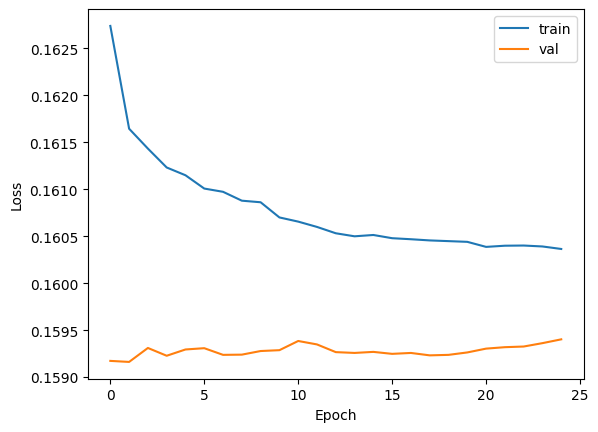

CPU times: user 35min 3s, sys: 10.1 s, total: 35min 14s
Wall time: 35min 37s


In [13]:
%%time
# Training the model
train_losses = []
val_losses = []

epochs = 25
for epoch in range(epochs):
    train_loss = 0.0
    model.train()
    for user, item, relevance_score,itemimage_embedding,itemdesc_embedding in train_loader:
        optimizer.zero_grad()
        user=user.view(-1, 1).to(device)
        item = item.view(-1, 1).to(device)
        relevance_score= relevance_score.to(device)
        itemimage_embedding=itemimage_embedding.to(device)
        itemdesc_embedding=itemdesc_embedding.to(device)
        #relevance_score = relevance_score.squeeze()
        #relevance_score = relevance_score.view(-1, 1).float()
        predicted_score = model(user, item,itemimage_embedding,itemdesc_embedding)
        # print(relevance_score)
        # print(predicted_score)
        loss = criterion(predicted_score, relevance_score.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_loader))

  # Validation
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for user, item, relevance_score,itemimage_embedding,itemdesc_embedding in val_loader:
            user=user.view(-1, 1).to(device)
            item = item.view(-1, 1).to(device)
            relevance_score= relevance_score.to(device)
            itemimage_embedding=itemimage_embedding.to(device)
            itemdesc_embedding=itemdesc_embedding.to(device)
            #relevance_score = relevance_score.squeeze()
            predicted_score = model(user, item,itemimage_embedding,itemdesc_embedding)
            loss = criterion(predicted_score, relevance_score.float())
            val_loss += loss.item()
        val_losses.append(val_loss/len(val_loader))

# Print the loss for each epoch
    print(f"Epoch {epoch+1}, Training Loss: {train_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Plot loss curves
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
%%time
torch.save(model, MODEL_PATH)
model = torch.load(MODEL_PATH)

CPU times: user 17 ms, sys: 6.98 ms, total: 24 ms
Wall time: 51.9 ms


In [15]:
###Testing the Model with HIT 10
# User-item pairs for testing
test_user_item_set = set(zip(test_data['reviewerID'], test_data['asin']))
# Dict of all items that are interacted with by each user
user_interacted_items = train_data.groupby('reviewerID')['asin'].apply(list).to_dict()
all_Ids = train_data['asin'].unique()


hits = []
ndcg=[]
auc=[]

for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_Ids) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]

    item_image_embedding_tensors = [image_embeddings.get(idx_to_item[item_id],torch.zeros(25088)) for item_id in test_items]
    item_desc_embedding_tensors = [description_embeddings.get(idx_to_item[item_id],torch.zeros(768)) for item_id in test_items]

    item_image_embedding_tensors = torch.stack(item_image_embedding_tensors)
    item_desc_embedding_tensors= torch.stack(item_desc_embedding_tensors)
    
    predicted_labels = np.squeeze(model(torch.tensor([u]*100).view(-1,1).to(device),\
                                        torch.tensor(test_items).view(-1,1).to(device),\
                                        item_image_embedding_tensors.to(device),item_desc_embedding_tensors.to(device))\
                                        .detach().cpu().numpy())
    
    
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    actual_labels = np.zeros(100)
    actual_labels[-1] = 1
    
    # NDCG calculation
    ndcg.append(ndcg_score([actual_labels], [predicted_labels]))

    # AUC calculation
    auc.append(roc_auc_score(actual_labels, predicted_labels))
    

    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)
        
print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))
print("The AUC is {:.2f}".format(np.average(auc)))
print("The NDCG is {:.2f}".format(np.average(ndcg)))

  0%|          | 0/14180 [00:00<?, ?it/s]

The Hit Ratio @ 10 is 0.12
The AUC is 0.52
The NDCG is 0.22
